In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import statistics


def set_size(fraction_width=0.95, fraction_height=0.25):
    width_pt = 241.14749 # column width in pt
    height_pt = 626.0 # page height in pt

    fig_width_pt = width_pt * fraction_width
    fig_height_pt = height_pt * fraction_height
    inches_per_pt = 1 / 72.27

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt

    return fig_width_in, fig_height_in

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set default background color for the plot area (axes)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'black'     
plt.rcParams['ytick.color'] = 'black'      
plt.rcParams['axes.labelcolor'] = 'black'    
plt.rcParams['axes.edgecolor'] = 'black'     
plt.rcParams['font.size'] = '12'    

def create_dict():
    return {"Execution": [], "Optimization": []}

colors = {'ResultDB_Decompose': 'blue', 'ResultDB_SemiJoin':'green', 'TD_Root': 'brown', 'DP_Fold': 'red', 'DP_Fold-Greedy': 'orange', 'DP_ResultDB': 'violet'}
alg_to_latex = {'ResultDB_Decompose': r'ResultDB$_{\text{Decompose}}$', 'ResultDB_SemiJoin': r'ResultDB$_{\text{Semi-Join}}$','TD_Root': r'TD$_{\text{Root}}$', 'DP_Fold': r'DP$_{\text{Fold}}$', 'DP_Fold-Greedy': r'DP$_{\text{Fold-Greedy}}$', 'DP_ResultDB': r'DP$_{\text{ResultDB}}$'}


# !!!!!!!!!!!!!!!!!!!!!!!! ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!
# If you want to create the visualization for the existing results in the repository, set the parameter 'use_existing_results' to 'True',
# if you want to create the visualization for the newly results in your rerun of the experiments, set it to 'False'
use_existing_results: bool = True
# !!!!!!!!!!!!!!!!!!!!!!!! ATTENTION !!!!!!!!!!!!!!!!!!!!!!!!
result_path: str = "existing_results" if use_existing_results else "recreated_results"

# Enumeration Time Experiments

## Star Benchmarks

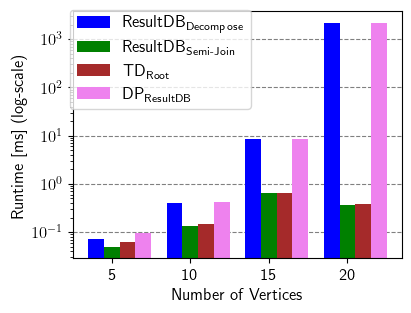

In [2]:
algorithm_times = {
    'ResultDB_Decompose': [],
    'ResultDB_SemiJoin': [],
    'TD_Root': [],
    'DP_ResultDB': []
}

sizes = [5, 10, 15, 20]
data = pd.read_csv(f'./enumeration_time/{result_path}/star.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "TD_Root" in algorithm:
            algorithm_times['TD_Root'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'].append(execution_time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
            

x = np.arange(len(sizes))  
width = 0.2  
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.14, 1.02), loc='upper left')

fig.savefig(f'./enumeration_time/{result_path}/star_benchmark_results.pdf')


## Chain Queries

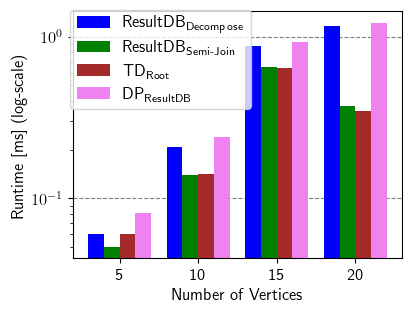

In [3]:
algorithm_times = {
    'ResultDB_Decompose': [],
    'ResultDB_SemiJoin': [],
    'TD_Root': [],
    'DP_ResultDB': []
}

sizes = [5, 10, 15, 20]
data = pd.read_csv(f'./enumeration_time/{result_path}/chain.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "TD_Root" in algorithm:
            algorithm_times['TD_Root'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'].append(execution_time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
            

x = np.arange(len(sizes)) 
width = 0.2 
multiplier = -0.5
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.14, 1.02), loc='upper left')

fig.savefig(f'./enumeration_time/{result_path}/chain_benchmark_results.pdf')

## Cycle Benchmarks

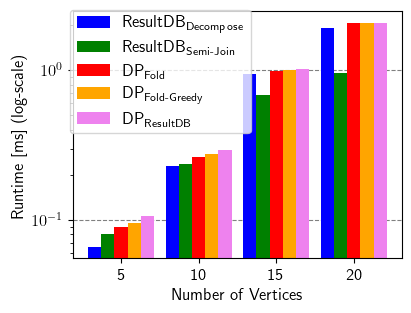

In [4]:
algorithm_times = {
    'ResultDB_Decompose': [],
    'ResultDB_SemiJoin': [],
    'DP_Fold': [],
    'DP_Fold-Greedy': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv(f'./enumeration_time/{result_path}/cycle.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'].append(execution_time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'].append(execution_time)
        elif "Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'].append(execution_time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"

x = np.arange(len(sizes))  
width = 0.17  
multiplier = -1
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.14, 1.02), loc='upper left')

fig.savefig(f'./enumeration_time/{result_path}/cycle_benchmark_results.pdf')

# Two-Vertex Cuts

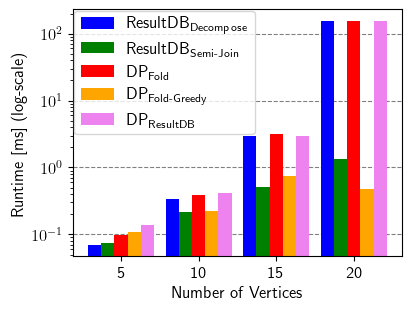

In [5]:
algorithm_times = {
    'ResultDB_Decompose': [],
    'ResultDB_SemiJoin': [],
    'DP_Fold': [],
    'DP_Fold-Greedy': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv(f'./enumeration_time/{result_path}/tvc.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'].append(execution_time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'].append(execution_time)
        elif "Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'].append(execution_time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"

x = np.arange(len(sizes))  
width = 0.17
multiplier = -1
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.15, 1.01), loc='upper left')

fig.savefig(f'./enumeration_time/{result_path}/tvc_benchmark_results.pdf')

# Synthetic Experiments

## Chain

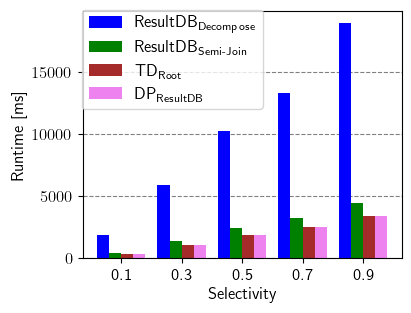

In [6]:
algorithm_times = {
    'ResultDB_Decompose': create_dict(),
    "ResultDB_SemiJoin": create_dict(),
    'TD_Root': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
    1,
    3,
    5,
    7,
    9,
]))
data = pd.read_csv(f'./synthetic/{result_path}/chain_synthetic.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'][key].append(time)
        elif "TD_Root" in algorithm:
            algorithm_times['TD_Root'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"

x = np.arange(len(queries)) 
width = 0.2  
multiplier = -0.5
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))

for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    multiplier += 1


ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.17, 1.02), loc='upper left')

fig.savefig(f'./synthetic/{result_path}/chain_benchmark_results.pdf')

## Cycle

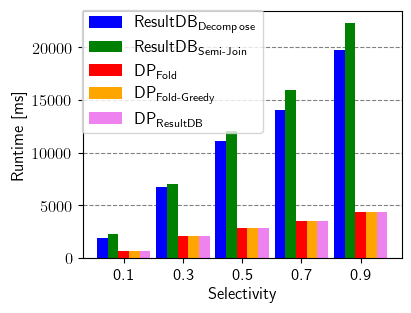

In [7]:
algorithm_times = {
    'ResultDB_Decompose': create_dict(),
    "ResultDB_SemiJoin": create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
    1,
    3,
    5,
    7,
    9,
]))
data = pd.read_csv(f'./synthetic/{result_path}/cycle_synthetic.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'][key].append(time)
        elif "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"

x = np.arange(len(queries))  
width = 0.18  
multiplier = -1
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.17, 1.02), loc='upper left')

fig.savefig(f'./synthetic/{result_path}/cycle_benchmark_results.pdf')

## Two-Vertex Cuts

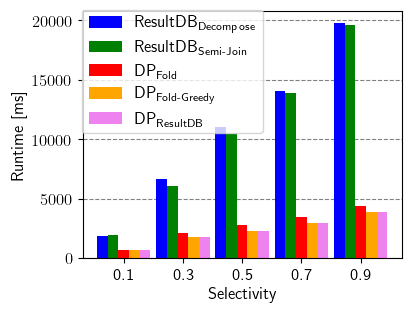

In [8]:
algorithm_times = {
    'ResultDB_Decompose': create_dict(),
    "ResultDB_SemiJoin": create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
    1,
    3,
    5,
    7,
    9,
]))
data = pd.read_csv(f'./synthetic/{result_path}/tvc_synthetic.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'][key].append(time)
        elif "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"

x = np.arange(len(queries))  
width = 0.18  
multiplier = -1
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.17, 1.02), loc='upper left')

fig.savefig(f'./synthetic/{result_path}/tvc_benchmark_results.pdf')

# Job Experiments

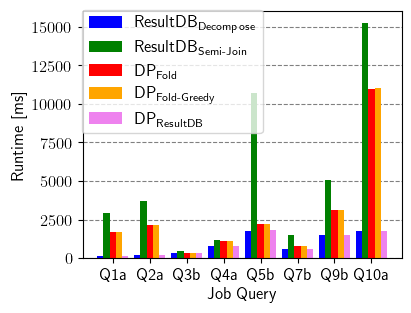

In [10]:
algorithm_times = {
    'ResultDB_Decompose': create_dict(),
    'ResultDB_SemiJoin': create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    'DP_ResultDB': create_dict(),
}


queries = [
    'Q1a',
    'Q2a',
    'Q3b',
    'Q4a',
    'Q5b',
    'Q7b',
    'Q9b',
    'Q10a'
]

data = pd.read_csv(f'./job/{result_path}/job.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'case', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['experiment'] == query]

    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "Decompose" in algorithm:
            algorithm_times['ResultDB_Decompose'][key].append(time)
        elif "Heuristic" in algorithm:
            algorithm_times['ResultDB_SemiJoin'][key].append(time)
        elif "Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"       

x = np.arange(len(queries))  
width = 0.17  
multiplier = -1
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm], color=colors[algorithm])
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Job Query')
ax.set_xticks(x + width, queries)
ax.set_ylim(0, 16000)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
fig.legend(bbox_to_anchor=(0.17, 1.02), loc='upper left')

fig.savefig(f'./job/{result_path}/job_benchmark_results.pdf')